
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [31]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [32]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(DATA_PATH+'lending-club/lending-club-subset.csv')
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Just use 36 month loans
history = history[history.term==' 36 months']

# Index & sort by issue date
history = history.set_index('issue_d').sort_index()

# Clean data, engineer feature, & select subset of features
history = history.rename(columns=                     
    {'annual_inc': 'Annual Income', 
     'fico_range_high': 'Credit Score', 
     'funded_amnt': 'Loan Amount', 
     'title': 'Loan Purpose'})

history['Interest Rate'] = history['int_rate'].str.strip('%').astype(float)
history['Monthly Debts'] = history['Annual Income'] / 12 * history['dti'] / 100

columns = ['Annual Income', 
           'Credit Score', 
           'Loan Amount', 
           'Loan Purpose', 
           'Monthly Debts', 
           'Interest Rate']

history = history[columns]
history = history.dropna()

# Test on the last 10,000 loans,
# Validate on the 10,000 before that,
# Train on the rest
test = history[-10000:]
val = history[-20000:-10000]
train = history[:-20000]

In [33]:
# Assign to X, y
target = 'Interest Rate'
features = history.columns.drop('Interest Rate')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

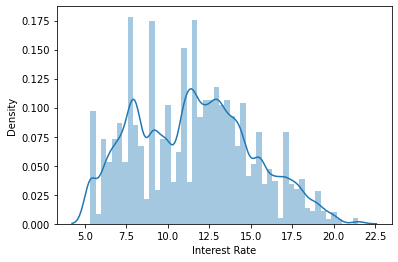

In [34]:
# The target has some right skew, but it's not too bad
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

# Fit Linear Regression Model

In [35]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.22422462337805615


## Explaining Linear Regression

In [36]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

Annual Income   -0.000003
Credit Score    -0.052736
Loan Amount      0.000018
Loan Purpose     1.000816
Monthly Debts   -0.000021
dtype: float64

## Fit Gradient Boosting Model

In [49]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.27488377264062747


In [48]:
from pdpbox.pdp import  pdp_isolate, pdp_plot

feature = 'Annual Income'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f355bae7f60>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f355a7659e8>})

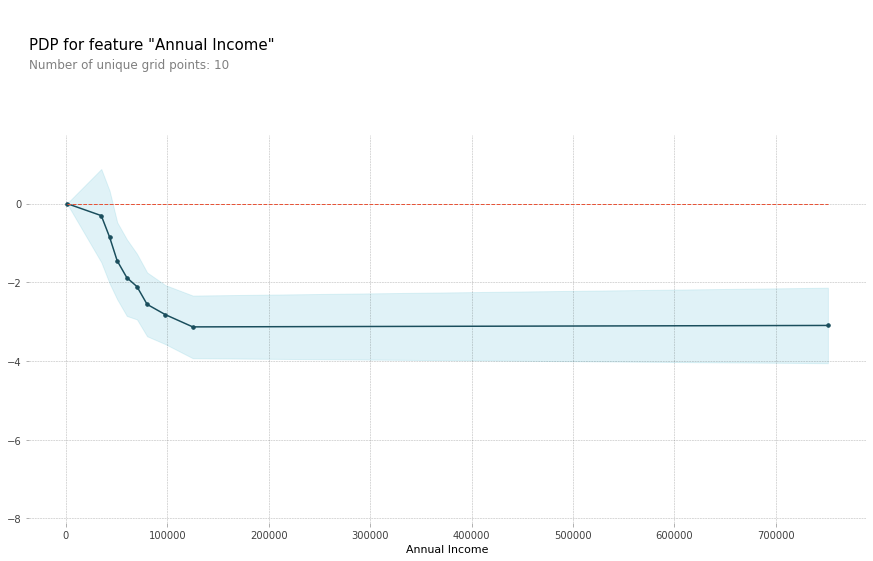

In [38]:
pdp_plot(isolated, feature_name=feature)

(20000.0, 150000.0)

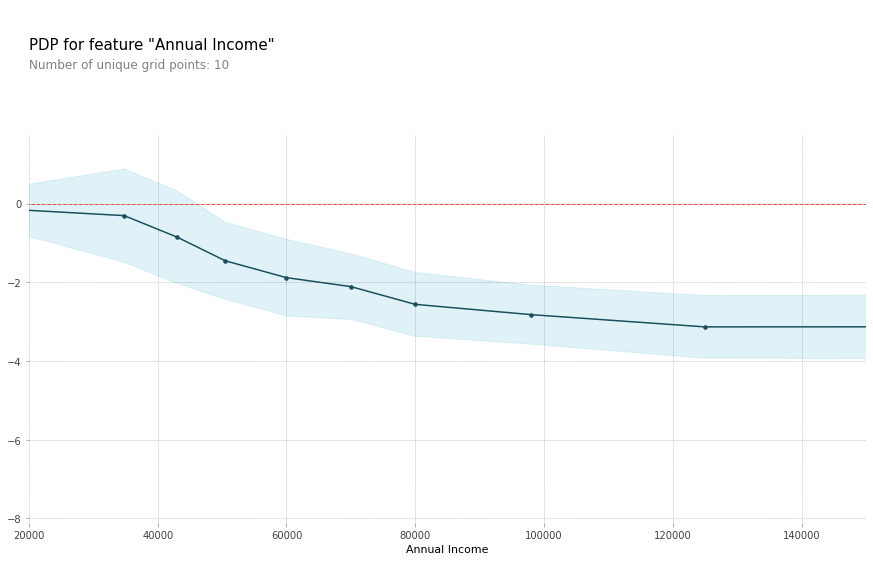

In [39]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((20000,150000))

(20000.0, 150000.0)

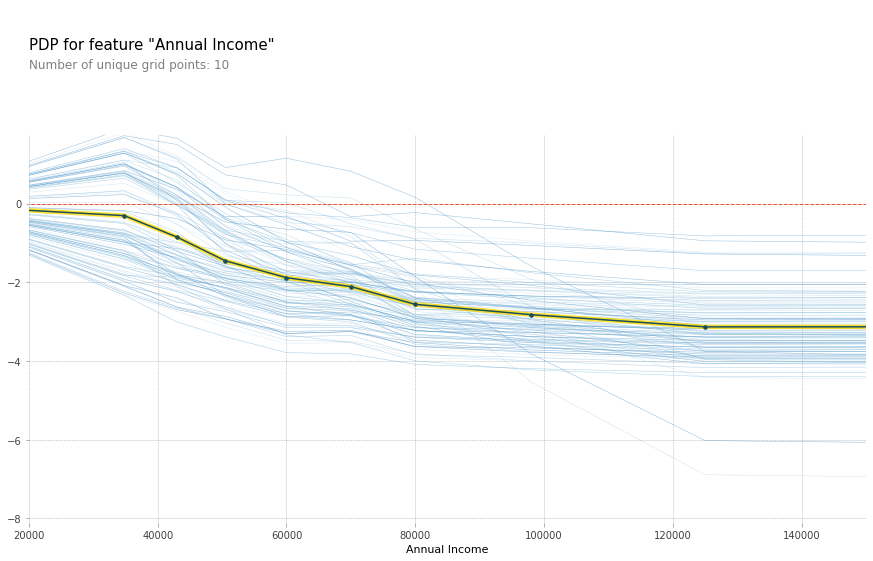

In [40]:
# plot a pdp with ICE curves
# PDP - Partial Dependence Plot
# ICE - Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)
plt.xlim((20000, 150000))

In [41]:
isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features = X_val.columns,
    feature=feature,
    num_grid_points=50
)

In [42]:
len(X_val)*50

500000

(20000.0, 150000.0)

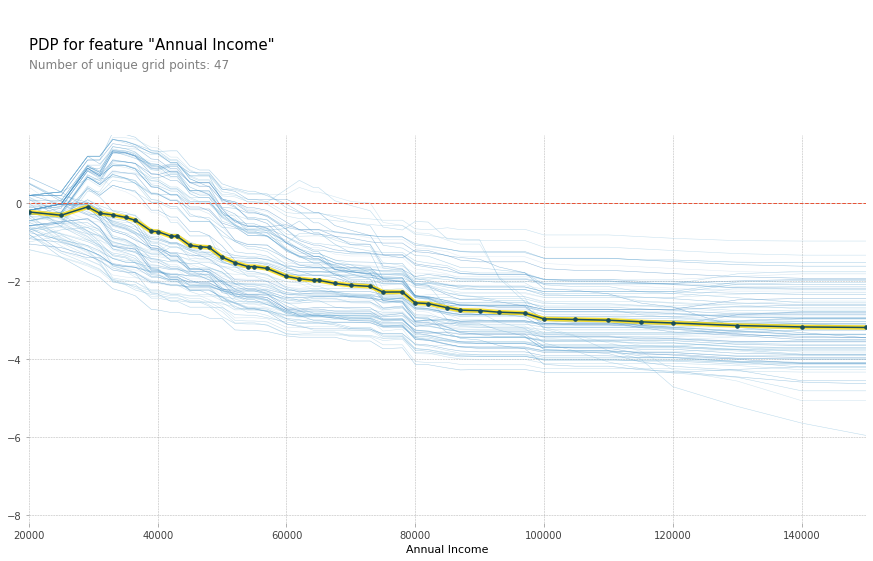

In [43]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)
plt.xlim((20000,150000))

## Partial Dependence with 1 feature

In [44]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [50]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Annual Income'
isolated = pdp_isolate(
    model = gb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

## Partial Dependence with 2 features

In [53]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Annual Income', 'Credit Score']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


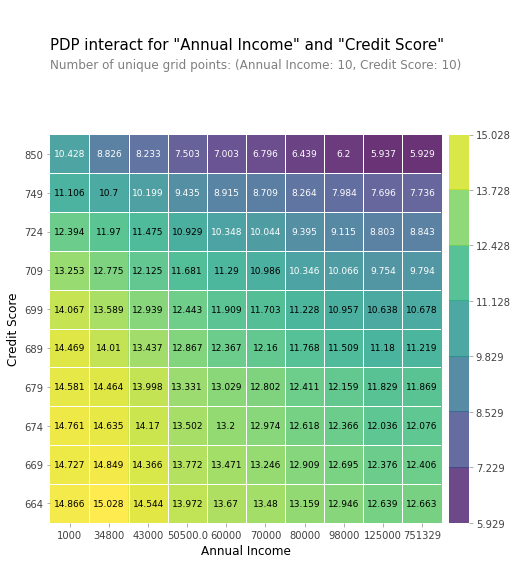

In [54]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

## Shapley



In [55]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

In [56]:
# Assign to X, y
features = ['bedrooms', 'bathrooms', 'longitude', 'latitude']
target = 'price'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [57]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.8s finished


In [58]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': None, 'max_features': 0.6011150117432088, 'n_estimators': 201}
Cross-validation MAE 375.95637690332126


In [59]:
# Get an individual observation to explain.
# For example, the 0th row from the test set.
row = X_test.iloc[[0]] 
row

,bedrooms,bathrooms,longitude,latitude
0,3,1.5,-73.9425,40.7145


In [60]:
# What was the actual rent for this apartment?
y_test.iloc[[0]]

0    3000
Name: price, dtype: int64

In [61]:
# What does the model predict for this apartment?
model.predict(row)

array([3293.49306498])

In [62]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

In [63]:
explainer.expected_value, y_train.mean()

(array([3575.72954331]), 3575.604007034292)

In [64]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps

(bedrooms, 3.0)          571.595298
(bathrooms, 1.5)         -45.094392
(longitude, -73.9425)   -963.949751
(latitude, 40.7145)      155.212367
dtype: float64

In [65]:
shaps.sum()
explainer.expected_value + shaps.sum() 

array([3293.49306498])